# Check Emotion Labeled Dataset

The main objective of this notebook is to show the output dataset from the sentiment analysis model

In [2]:
import os
import pandas as pd
from pathlib import Path

In [3]:
dataset_path = Path('../datasets/train_preprocess.csv').resolve()

In [4]:
dataset = pd.read_csv(dataset_path)

In [5]:
print('Train Size:',dataset.shape)

Train Size: (3521, 2)


In [6]:
val_data = Path('../datasets/valid_preprocess.csv').resolve()
val_dataset = pd.read_csv(dataset_path)
print('Size val:',val_dataset.shape)

Size val: (3521, 2)


In [7]:
dataset.head()

,label,text
0,happy,Ini adalah hal yang paling membahagiakan saat ...
1,anger,[USERNAME] [USERNAME] Dari pertama [USERNAME] ...
2,fear,yaudah kalo emang belum berani potong rambut p...
3,fear,"Jadi semalam, gw rekap, eh intinya yg gw usaha..."
4,anger,temen2 masa kecil yang turned out being asshol...


In [8]:
import seaborn as sns

# Label count

Check the count of each label

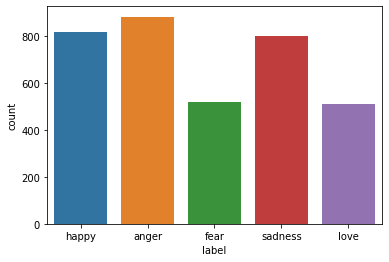

In [9]:
sns.countplot(x='label', data=dataset)

# Text length

Check the length of the tweets

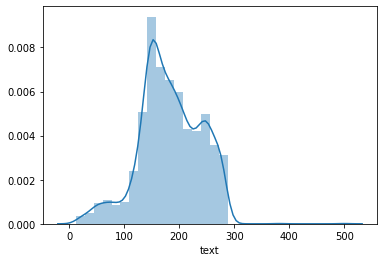

In [10]:
sns.distplot(dataset.text.apply(lambda text: len(text)), bins=30)

# Word count

Check the word count

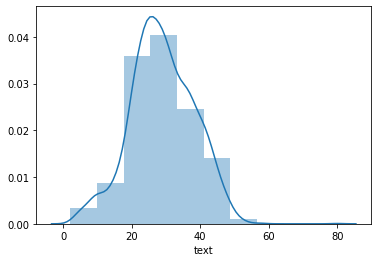

In [11]:
sns.distplot(dataset.text.apply(lambda text: len(text.split())), bins=10)

# Training

# Train Emotion Recognition Model

Here we'll train a emotion recognition model, using the output data from the sentiment analysis.

In [12]:
# Add project path to the PYTHONPATH

import os
import sys
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

# Load Dataset

Load the emotion labeled dataset

In [14]:
from pathlib import Path
import pandas as pd
from nlp import Dataset

[nltk_data] Downloading package stopwords to /home/shivam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
dataset_path = Path('../datasets/train_preprocess.csv').resolve()
dataset = Dataset(dataset_path)
dataset.load()
dataset.preprocess_texts()

Time to clean up: 2.11 sec


In [16]:
dataset.cleaned_data.head()

,label,text
0,happy,ini adalah hal yang paling membahagiakan saat ...
1,anger,username username dari pertama username mendud...
2,fear,yaudah kalo emang belum berani potong rambut p...
3,fear,jadi semalam gw rekap eh intinya yg gw usahain...
4,anger,temen masa kecil yang turned asshole itu kalo ...


# Tokenize

Transform the text corpus to a vector representation

- **num_words**: Number of words to use

In [17]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

In [18]:
num_words = 10000

tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer.fit_on_texts(dataset.cleaned_data.text)

file_to_save = Path('../datasets/tokenizer.pickle').resolve()
with file_to_save.open('wb') as file:
    pickle.dump(tokenizer, file)

# Split data

Split the dataset in train and validation data

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
data = dataset.cleaned_data.copy()

train = pd.DataFrame(columns=['label', 'text'])
validation = pd.DataFrame(columns=['label', 'text'])
for label in data.label.unique():
    label_data = data[data.label == label]
    train_data, validation_data = train_test_split(label_data, test_size=0.3)
    train = pd.concat([train, train_data])
    validation = pd.concat([validation, validation_data])

# Model

Define the **LSTM** + **CNN** model

In [21]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, concatenate
from tensorflow.keras.models import Model

In [22]:
input_dim = min(tokenizer.num_words, len(tokenizer.word_index) + 1)
num_classes = len(data.label.unique())
embedding_dim = 500
input_length = 100
lstm_units = 128
lstm_dropout = 0.1
recurrent_dropout = 0.1
spatial_dropout=0.2
filters=64
kernel_size=3

In [23]:
input_layer = Input(shape=(input_length,))
output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,)
)(input_layer)

output_layer = SpatialDropout1D(spatial_dropout)(output_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)
output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 500)     5000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 500)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 256)     644096      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

# Prepare the data

Prepare the model input data

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

In [26]:
train_sequences = [text.split() for text in train.text]
validation_sequences = [text.split() for text in validation.text]
list_tokenized_train = tokenizer.texts_to_sequences(train_sequences)
list_tokenized_validation = tokenizer.texts_to_sequences(validation_sequences)
x_train = pad_sequences(list_tokenized_train, maxlen=input_length)
x_validation = pad_sequences(list_tokenized_validation, maxlen=input_length)

encoder = LabelBinarizer()
encoder.fit(data.label.unique())

encoder_path = Path('../models/emotion_recognition_pickle', 'encoder.pickle')
with encoder_path.open('wb') as file:
    pickle.dump(encoder, file)

y_train = encoder.transform(train.label)
y_validation = encoder.transform(validation.label)

# Train model

Do the training process with the given data

In [27]:
batch_size = 128
epochs = 10

In [28]:
model.fit(
    x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_validation, y_validation)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2462 samples, validate on 1059 samples
Epoch 1/10
2462/2462 [==============================] - 85s 34ms/sample - loss: 1.5782 - acc: 0.2640 - val_loss: 1.5533 - val_acc: 0.2531
Epoch 2/10
2462/2462 [==============================] - 18s 7ms/sample - loss: 1.4214 - acc: 0.3989 - val_loss: 1.2755 - val_acc: 0.4674
Epoch 3/10
2462/2462 [==============================] - 17s 7ms/sample - loss: 0.8454 - acc: 0.7307 - val_loss: 1.0571 - val_acc: 0.5855
Epoch 4/10
2462/2462 [==============================] - 18s 7ms/sample - loss: 0.3539 - acc: 0.8956 - val_loss: 1.2651 - val_acc: 0.5892
Epoch 5/10
2462/2462 [==============================] - 17s 7ms/sample - loss: 0.1207 - acc: 0.9695 - val_loss: 1.4982 - val_acc: 0.6110
Epoch 6/10
2462/2462 [==============================] - 17s 7ms/sample - loss: 0.0291 - acc: 0.9955 - val_loss: 1.7847 - val_acc: 0.6043
Epoch 7/10
2462/2462 [=============

In [29]:
model_file = Path('../models/emotion_recognition_pickle/model_weights.h5').resolve()
model.save_weights(model_file.as_posix())

# Prediction


# Emotion Recognition Model Validation

The main objective of this notebook is to validate the trained model for emotion recognition

In [30]:
# Add project path to the PYTHONPATH

import os
import sys
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [31]:
import pickle

# Load Tokenizer

Load `.pickle` file with the tokenizer

In [32]:
tokenizer_path = Path('../datasets/tokenizer.pickle').resolve()
with tokenizer_path.open('rb') as file:
    tokenizer = pickle.load(file)

# Load Model

Load the trained emotion recognition model

In [34]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, concatenate
from tensorflow.keras.models import Model

In [35]:
input_dim = min(tokenizer.num_words, len(tokenizer.word_index) + 1)
num_classes = 4
embedding_dim = 500
input_length = 100
lstm_units = 128
lstm_dropout = 0.1
recurrent_dropout = 0.1
spatial_dropout=0.2
filters=64
kernel_size=3

In [36]:
input_layer = Input(shape=(input_length,))
output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,)
)(input_layer)

output_layer = SpatialDropout1D(spatial_dropout)(output_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)
output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)

In [37]:
model_weights_path = Path('../models/emotion_recognition_pickle/model_weights.h5').resolve()
model.load_weights(model_weights_path.as_posix())

# Load test dataset

Load the dataset that will be used to test the model

In [39]:
import pandas as pd

In [40]:
test_data_path = Path('../datasets/valid_preprocess.csv').resolve()
test_data = pd.read_csv(test_data_path)

In [41]:
test_data.head()

,label,text
0,anger,[USERNAME] jaringannya mati ya? Tidak bisa dib...
1,anger,It's like a circle of stupidity. Atlit gak diu...
2,anger,[USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...
3,happy,[USERNAME] Selamat Siang Sahabat Pos. Kiriman ...
4,happy,"Di hari ini, yap tepat di tanggal 23 juli dima..."


# Load Encoder

Load `.pickle` file with the encoder

In [42]:
encoder_path = Path('../models/emotion_recognition_pickle/encoder.pickle').resolve()
with encoder_path.open('rb') as file:
    encoder = pickle.load(file)

# Preprocess data

Preprocess the data that will be used

In [43]:
from nlp.utils import preprocess
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
test_data['text'] = preprocess(test_data.text)
sequences = [text.split() for text in test_data.text]
list_tokenized = tokenizer.texts_to_sequences(sequences)
x_test = pad_sequences(list_tokenized, maxlen=100)
y_test = encoder.transform(test_data.label)

Time to clean up: 0.33 sec


# Results

Predict the labels and generate a confusion matrix

In [45]:
y_pred = model.predict(x_test)

In [46]:
y_pred = y_pred.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [48]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

Normalized confusion matrix
[[0.71818182 0.06363636 0.05454545 0.02727273 0.13636364]
 [0.06153846 0.67692308 0.10769231 0.01538462 0.13846154]
 [0.14705882 0.03921569 0.45098039 0.06862745 0.29411765]
 [0.0625     0.03125    0.109375   0.71875    0.078125  ]
 [0.14141414 0.1010101  0.14141414 0.11111111 0.50505051]]


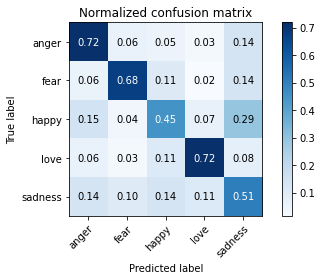

In [49]:
fig, ax = plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)
fig.savefig('confusion_matrix.png')

In [51]:

from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


precision: [0.68103448 0.65671642 0.575      0.67647059 0.4587156 ]
recall: [0.71818182 0.67692308 0.45098039 0.71875    0.50505051]
fscore: [0.69911504 0.66666667 0.50549451 0.6969697  0.48076923]
support: [110  65 102  64  99]
